# 0. Library Import

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import time
import cv2
import random
import gc
import warnings

from PIL import Image
from glob import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import SimpleITK as sitk
import pydicom as dcm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
from torchvision.transforms import *
from torchvision.transforms import Compose

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.autograd import Variable

In [2]:
CFG={'Image_Size':256,
    'EPOCHS':100,
    'BATCH_SIZE':8,
    'Learning_rate':1e-3,
    'beta_1':0.9,
    'beta_2':0.99,
    'eps':0.00000001,
     'weight_decay':0.000001,
    'Channel_size':8,
    'SEED':42}

In [3]:
warnings.filterwarnings('ignore')

# 1. Check Gpu Server

In [4]:
if torch.cuda.is_available():
    device="cuda"
else:
    device="cpu"
    
print(f"device  : {device}")

device  : cuda


In [5]:
print(f"Name of the graphic card : {torch.cuda.get_device_name(0)}")
print(f"Number of gpu : {torch.cuda.device_count()}")

Name of the graphic card : NVIDIA GeForce RTX 4090
Number of gpu : 2


### Make Trash can

In [6]:
gc.collect()
torch.cuda.empty_cache()

### Seed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

seed_everything(CFG['SEED'])

# 2. Get Data Path

In [8]:
path_asd='C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\'
path_control='C:\\Users\\PC00\\Desktop\\ASD_data\\CONTROL\\'

asd_p=os.listdir(path_asd)
control_p=os.listdir(path_control)

MRI_image=['MAGIC_T2']
all_image_path=[]

for name in asd_p:
    path=''
    for image in MRI_image:
        path=path_asd+name+'\\'+'aNew'+'\\'
        path=path+image+'\\'
        if 'Test' in path or '3564' in path or '3395' in path or '3278' in path or '3466' in path or '3624' in path or '3603' in path or '3632' in path or '3663' in path:
            pass
        else:
            all_image_path.append(path)
print("ASD Image Data : " , len(all_image_path)) 
for name in control_p:
    path=''
    for image in MRI_image:
        path=path_control+name+'\\'+'aNew'+'\\'
        path=path+image+'\\'
        if 'Test' in path or '3564' in path or '3395' in path or '3278' in path or '3466' in path or '3624' in path or '3603' in path or '3632' in path or '3663' in path:
            pass
        else:
            all_image_path.append(path)
        
print("ASD+TC Image Data : " ,len(all_image_path))

ASD Image Data :  203
ASD+TC Image Data :  261


In [9]:
for info in all_image_path:
    print(info)    

C:\Users\PC00\Desktop\ASD_data\ASD\1101_ASY\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1111_KJW\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1113_LJH\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1321_KSH\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1332_LJM\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1542_KYL\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1543_BYS\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1563_CYS\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1659_YHS\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1692_CMK\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1694_LDW\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1712_SHJ\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1727_SYS\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1734_PJW\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1736_KSJ\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1746_YDK\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\1751_CYS\aNew\MAGIC_T

# 3. Make Label

In [10]:
label=np.array([1]*203+[0]*(261-203), dtype=np.int64)

In [11]:
print(len(label))

261


In [12]:
n=np.unique(label, axis=0)
n=n.shape[0]

label=np.eye(n)[label]
print(n)

2


# 4. Divide Data path

Fix Test set for 20

In [13]:
test_asd='C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\Test\\'
test_control='C:\\Users\\PC00\\Desktop\\ASD_data\\CONTROL\\Test\\'

test_asd_p=os.listdir(test_asd)
test_control_p=os.listdir(test_control)

#MRI_image=['SPGR_P','MAGIC_T2']
MRI_image=['MAGIC_T2']
test_image_path=[]

for name in test_asd_p:
    path=''
    for image in MRI_image:
        path=test_asd+name+'\\'+'aNew'+'\\'
        path=path+image+'\\'
        test_image_path.append(path)
print("Test ASD Image Data : " , len(test_image_path)) 
for name in test_control_p:
    path=''
    for image in MRI_image:
        path=test_control+name+'\\'+'aNew'+'\\'
        path=path+image+'\\'
        test_image_path.append(path)
        
print("Test ASD+TC Image Data : " ,len(test_image_path))

Test ASD Image Data :  10
Test ASD+TC Image Data :  20


In [14]:
for p in test_image_path:
    print(p)

C:\Users\PC00\Desktop\ASD_data\ASD\Test\4837_KDK_DL\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\4838_KKW_DL\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\4839_PRK_DL\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\4859_PJH_DL\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\4881_JWJ\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\5010_PHS\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\5023_PDK\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\5036_HKM\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\5102_KMJ\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\5115_HW\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\CONTROL\Test\4371_SHJ\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\CONTROL\Test\4582_MSH\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\CONTROL\Test\4808_KTH\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\CONTROL\Test\4917_JSO\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\CONTROL\Test\4931_LSY\aNew\MAGIC_T2\
C:\Users\

In [15]:
test_label=np.array([1]*10+[0]*10, dtype=np.int64)

In [16]:
print(len(test_label))

20


In [17]:
n=np.unique(test_label, axis=0)
n=n.shape[0]

test_label=np.eye(n)[test_label]
print(n)

2


Train : Val = 0.8 : 0.2

In [18]:
train_path, val_path, train_label, val_label=train_test_split(all_image_path, label, test_size=0.3, random_state=CFG['SEED'])

In [19]:
print(len(train_path), len(val_path), len(train_label), len(val_label))

182 79 182 79


In [20]:
train_asd=0
train_tc=0
for path in train_path:
    if 'CONTROL' in path:
        train_tc+=1
    
train_asd=len(train_path)-train_tc      
print("Train ASD : ", train_asd)
print("Train TC : ", train_tc)

Train ASD :  142
Train TC :  40


In [21]:
val_asd=0
val_tc=0
for path in val_path:
    if 'CONTROL' in path:
        val_tc+=1
    
val_asd=len(val_path)-val_tc      
print("Val ASD : ", val_asd)
print("Val TC : ", val_tc)

Val ASD :  61
Val TC :  18


# 5. Transform and augmentation

## Transform

### Resize

In [22]:
pad_image=[[0]*256]*256

In [23]:
def T1_resize(img_volume, plus_image):
    #(256, 256, 188)
    
    want_channel=188
    original_channel=img_volume.shape[0]
    difference=abs(want_channel-original_channel)
  
    #차이가 짝수이면
    if difference==0:
        return img_volume
    else:
        img_volume=list(img_volume)
        if difference%2==0:
            #front & behind
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)
        
        else:
            #front
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
            #behind    
            for _ in range(difference//2+1):
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)

In [24]:
def T2_resize(img_volume, plus_image):
    #(256, 256, 34)
    
    want_channel=34
    original_channel=img_volume.shape[0]
    difference=abs(want_channel-original_channel)
  
    if difference==0:
        return img_volume
    else:
        img_volume=list(img_volume)
        #차이가 짝수이면
        if difference%2==0:
            #front & behind
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)
        
        else:
            #front
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
            #behind    
            for _ in range(difference//2+1):
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)

### cropping

In [25]:
def T1_crop(img_volume):
    area=(25, 45, 215, 210)
    img_crop_volume=[]
    for i in range(img_volume.shape[0]):
        img=img_volume[i]
    
        img=Image.fromarray(np.uint16(img))

        img=img.crop(area)
        
        img=np.array(img)
        img=list(img)
        img_crop_volume.append(img)
  
    img_crop_volume=np.array(img_crop_volume)
    return img_crop_volume

In [26]:
def T2_crop(img_volume):
    area=(40, 20, 225, 225)
    img_crop_volume=[]
    for i in range(img_volume.shape[0]):
        img=img_volume[i]
    
        img=Image.fromarray(np.uint16(img))

        img=img.crop(area)
        
        img=np.array(img)
        img=list(img)
        img_crop_volume.append(img)
  
    img_crop_volume=np.array(img_crop_volume)
    return img_crop_volume

### MinMaxScaler

In [27]:
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X,y=None):
        x=np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

In [28]:
scaler = MinMaxScaler3D()

## Augmentation

# 6. Get Image from data path

Convert to numpy (dicom -> numpy)

In [29]:
def convert_to_numpy(sitk_volume, size):
    """convert sitk image to numpy volume"""
    img_volume = sitk.GetArrayFromImage(sitk_volume)
    img_volume = img_volume.transpose(2,1,0)
    #print(img_volume.shape)
    if img_volume.shape[0]!=CFG['Image_Size']:
        img_volume = cv2.resize(img_volume, dsize=(CFG['Image_Size'], CFG['Image_Size']))
    
    #img_volume = img_volume.transpose(1,2,0)
    
    return img_volume

In [30]:
def get_image(path):
    reader=sitk.ImageSeriesReader()
    dicom_names=reader.GetGDCMSeriesFileNames(path)
    
    #print("Number of Series : ", len(dicom_names))
    
    reader.SetFileNames(dicom_names)
    
    image=reader.Execute()
    size=image.GetSize()
    #print("Original size of series : ", size[0], size[1], size[2])
    img_volume=convert_to_numpy(image, size)
    
    img_volume=img_volume.transpose(2,1,0)
    
    if 'SPGR_P' in path:
        img_volume=T1_resize(img_volume, pad_image)
        img_volume=T1_crop(img_volume)
    elif 'MAGIC_T2' in path:
        img_volume=T2_resize(img_volume, pad_image)
        img_volume=T2_crop(img_volume)
    #print("Convert size of series : ", img_volume.shape[0], img_volume.shape[1], img_volume.shape[2])
    img_volume = scaler.fit_transform(img_volume)
    return img_volume

# 7. CustomDataset

In [31]:
#T1+T2
class CustomDataset(Dataset):
    def __init__(self, path,labels, transforms=None):
        self.path=path
        self.labels=torch.from_numpy(labels)
        self.transforms=transforms
        
    def __getitem__(self, idx):
        #add label
        state=self.labels[idx]
        state=state.cuda()
        
        image=get_image(self.path[idx])
        image=np.array(image, dtype=np.int64)
        image=torch.from_numpy(image)
        
        image=torch.reshape(image,(1,image.shape[0], image.shape[1], image.shape[2]))
        
        if self.transforms:
            image = self.transforms(image)
        
        image=image.cuda()
        
        return image, state
        
    def __len__(self):
        return len(self.labels)   

In [32]:
train_data=CustomDataset(train_path, train_label)
val_data=CustomDataset(val_path, val_label)

test_data=CustomDataset(test_image_path, test_label) # 나중에 augmentation할 때 적용 하면 안됨

In [33]:
n=random.randint(0,len(train_label))
print(n)

163


In [34]:
train_data.__getitem__(n)[0].shape

torch.Size([1, 34, 205, 185])

In [35]:
train_dataloader=DataLoader(train_data, batch_size=CFG['BATCH_SIZE'],shuffle=True)
validation_dataloader=DataLoader(val_data, batch_size=CFG['BATCH_SIZE'], shuffle=True)
test_dataloader=DataLoader(test_data, batch_size=CFG['BATCH_SIZE'],shuffle=True)

In [36]:
train_features, train_labels=next(iter(train_dataloader))

# 8. Model

## 3D CSResNet Model = CS Block + 3D ResNet Model

## CS Block
Channel block + spatial block

In [37]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg','max']):
        super(ChannelGate, self).__init__()
        self.gate_channels=gate_channels
        self.mlp=nn.Sequential(
                        Flatten(),
                        nn.Linear(gate_channels, gate_channels // reduction_ratio),
                        nn.ReLU(),
                        nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
        self.pool_types=pool_types
        
    def forward(self, x):
        channel_att_sum=None
        #print("Input of Channel gate shape : ", x.size(0), x.size(1), x.size(2), x.size(3)) # 8 64 17 64 64
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool3d( x, (x.size(2), x.size(3), x.size(4)), stride=(x.size(2), x.size(3), x.size(4)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool3d( x, (x.size(2), x.size(3), x.size(4)), stride=(x.size(2), x.size(3), x.size(4)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool3d( x, (x.size(2), x.size(3), x.size(4)), stride=(x.size(2), x.size(3), x.size(4)))
                channel_att_raw = self.mlp( lp_pool )
                
            if channel_att_sum is None:
                channel_att_sum=channel_att_raw
            else:
                channel_att_sum=channel_att_sum+channel_att_raw
                
        scale = F.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).unsqueeze(4).expand_as(x)
        return x*scale

In [38]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm3d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

In [39]:
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size=7
        self.compress=ChannelPool()
        self.spatial=BasicConv(2,1, kernel_size, stride=1, padding=(kernel_size-1)//2, relu=False)
        
    def forward(self, x):
        x_compress=self.compress(x)
        x_out=self.spatial(x_compress)
        scale=F.sigmoid(x_out) #broadcasting
        return x*scale

In [40]:
class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg','max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate=ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate=SpatialGate()
            
    def forward(self, x):
        x_out=self.ChannelGate(x)
        if not self.no_spatial:
            x_out=self.SpatialGate(x_out)
            
        return x_out

## 3D ResNet

In [41]:
def get_inplanes():
    return [64, 128, 256, 512]

def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)

def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None, CBAM_use=False):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride
        self.dropout=nn.Dropout(0.2)
        
        if CBAM:
            self.cbam=CBAM(planes, 16)
        else:
            self.cbam=None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
            
        if not self.cbam is None:
            out=self.cbam(out)

        out += residual
        out = self.relu(out)
        
        return out

In [42]:
class ResNet18(nn.Module):
    def __init__(self, 
                 block, #Basicblock
                 layers, #[2,2,2,2]
                 block_inplanes, #[64, 128, 256, 512]
                 in_channels, #1
                 out_channels, #64
                 shortcut_type='B',
                 att_type=None,
                 stride=2, 
                 n_classes=2): #1, 64
        super().__init__()

        self.in_planes=block_inplanes[0]
        self.no_max_pool=False

        self.conv1=nn.Conv3d(in_channels, self.in_planes, kernel_size=(7,7,7), stride=(1,2,2), padding=(7//2,3,3), bias=False)
        self.bn1=nn.BatchNorm3d(out_channels)
        self.relu=nn.ReLU(inplace=True) #? -> 기존의 데이터를 연산의 결괏값으로 대체하는 것
        self.maxpool=nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        
        self.layer1=self._make_layer(block, block_inplanes[0], layers[0], shortcut_type)
        self.layer2=self._make_layer(block, block_inplanes[1], layers[1], shortcut_type, stride=2)
        self.layer3=self._make_layer(block, block_inplanes[2], layers[2], shortcut_type, stride=2)
        self.layer4=self._make_layer(block, block_inplanes[3], layers[3], shortcut_type, stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1,1,1))
        self.fc=nn.Linear(block_inplanes[3]*block.expansion, n_classes)
        self.sigmoid=torch.nn.Sigmoid()
        self.log_softmax=torch.nn.LogSoftmax()
        self.softmax=torch.nn.Softmax()
        
        if att_type=='BAM':
            self.bam1=BAM(64*block.expansion)
            self.bam2=BAM(128*block.expansion)
            self.bam3=BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3=None, None, None
        
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # He initialization
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1) # 초기값  설정
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample=None
        if stride!=1 or self.in_planes != planes*block.expansion:
            if shortcut_type=='A':
                downsample=partial(self._dwonsample_basic_block, planes=planes * block.expansion, stride=stride)
            else:
                downsample=nn.Sequential(
                    conv1x1x1(self.in_planes, planes*block.expansion, stride),
                    nn.BatchNorm3d(planes*block.expansion),
                )

        layers=[]
        layers.append(
            block(in_planes=self.in_planes, planes=planes, stride=stride, downsample=downsample, CBAM_use=True),
        )
        

        self.in_planes=planes*block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes, CBAM_use=True))

        return nn.Sequential(*layers)

    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        if not self.no_max_pool:
            x=self.maxpool(x)

        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)

        x=self.avgpool(x)
        
        x=x.view(x.size(0), -1)
        #print(f"x shape : {x.shape}\{x}")
        x=self.fc(x)
        #print(f"x shape : {x.shape}\{x}")
        #x=self.sigmoid(x)
        x=self.softmax(x)
        #print(f"x shape : {x.shape}\{x}")
        return x

In [43]:
model=ResNet18(BasicBlock, [2,2,2,2], get_inplanes(), 1, 64)

In [44]:
model=model.to(device)

In [45]:
model

ResNet18(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (cbam): CBAM(
        (ChannelGate): ChannelGate(
          (mlp): Sequential(
            (0): Flatten()
            (1): Linear(in_features=64, out_features=4, bias

In [46]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 33,255,610 trainable parameters


# 9. Define Loss Function and Optimizer

In [47]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        print(type(logpt), logpt.shape)
        print(logpt)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [67]:
loss_fn=nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.Adam(model.parameters(), 
                           lr=CFG['Learning_rate'], 
                           betas=(CFG['beta_1'], CFG['beta_2']), 
                           eps=CFG['eps'], 
                           weight_decay=CFG['weight_decay'])

TypeError: cross_entropy() missing 2 required positional arguments: 'input' and 'target'

# 10. EarlyStopping

### EarlyStopping

### ReduceLROnPlateau

In [49]:
#mode, factor, patience, threshold, cooldown, eps
LR_condition={'mode':'min',
            'factor' : 0.5,
            'patience' : 5}

In [50]:
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                               mode=LR_condition['mode'], 
                                               factor=LR_condition['factor'], 
                                               patience=LR_condition['patience'] )

# 11. KFold

# 12. Train & Validation

In [51]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler):
    
    size=len(dataloader.dataset)
    print("데이터 사이즈 : ", size)
    
    train_loss, correct=0,0
    #scheduler.step()
    model.train()
    
    #autograd engine(gradient를 계산해주는 context)을 비활성화 시켜 필요한 메모리를 줄여주고 연산속도 증가
    
    for batch, (X,y) in (enumerate((dataloader))):
        X=Variable(X.to(device).float())
        y=Variable(y.to(device).float())
        pred=model(X)
        loss=loss_fn(pred,y)
        print(f"pred {pred}")
    
        #L2 norm
        L2_lambda=0.0001
        L2_norm=sum(p.pow(2.0).sum() for p in model.parameters())
        
        loss=loss+L2_lambda/2*L2_norm
        
        train_loss+=loss.item()
        correct+=(pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
 
        #역전파
        optimizer.zero_grad() #gradient를 0으로 초기화
        loss.requires_grad_(True)
        loss.backward() #비용 함수를 미분하여 gradient 계산
        optimizer.step() #update weight and bias
        
        if batch%10==0:
            loss, current=loss.item(), batch*len(X)
            print(f"Batch {batch} loss : {loss:>7f} [{current:>5d}/{size:>5d}]")  
        
    train_loss/=size
    correct/=size
    
    print(f"Train\n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {train_loss:>8f}\n")
    return train_loss, correct

In [52]:
def val_loop(dataloader, model, loss_fn, scheduler):
    size=len(dataloader.dataset)
    
    num_batches=len(dataloader)
    val_loss, correct=0,0
    
    model.eval()
    with torch.no_grad():
        for X,y in dataloader:
            X=Variable(X.to(device).float())
            y=Variable(y.to(device).float())
            pred=model(X)
            
            loss=loss_fn(pred,y)
            
            #L2 norm
            L2_lambda=0.0001
            L2_norm=sum(p.pow(2.0).sum() for p in model.parameters())
            loss=loss+L2_lambda/2*L2_norm
            
            val_loss+=loss.item()
            
            #scheduler.step(val_loss)
            
            correct+=(pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
            
    val_loss/=num_batches
    correct/=size
    
    print(f"Validation\n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {val_loss:>8f}\n")
    return val_loss, correct

In [53]:
train_loss_info=[]
train_acc_info=[]

val_loss_info=[]
val_acc_info=[]

start=time.time()

for t in range(CFG['EPOCHS']):
    print(f"Epoch {t+1}\n-------------------------------------------")
    start_epoch=time.time()
    train_loss, train_acc=train_loop(train_dataloader, model, loss_fn, optimizer, scheduler)
    train_loss_info.append(train_loss)
    train_acc_info.append(train_acc)
    
    val_loss, val_acc=val_loop(validation_dataloader, model, loss_fn, scheduler)
    val_loss_info.append(val_loss)
    val_acc_info.append(val_acc)
    
    end_epoch=time.time()
    print(f"Epcoh time : {(end_epoch-start_epoch)//60}분 {(end_epoch-start_epoch)%60} 초")
    print(f"Epoch {t+1} End\n-------------------------------------------")
    print()
    
end=time.time()

print("Epoch 걸린 시간 : ", (end-start)//60, " 분", (end-start)%60, " 초")

Epoch 1
-------------------------------------------
데이터 사이즈 :  182
Batch 0 loss : 1.352553 [    0/  182]
Batch 10 loss : 1.125733 [   80/  182]
Batch 20 loss : 1.035483 [  160/  182]
Train
 Accuracy : 76.4%, Avg Loss : 0.150293

Validation
 Accuracy : 77.2%, Avg Loss : 1.249885

Epcoh time : 0.0분 54.844430923461914 초
Epoch 1 End
-------------------------------------------

Epoch 2
-------------------------------------------
데이터 사이즈 :  182
Batch 0 loss : 1.257246 [    0/  182]
Batch 10 loss : 1.236699 [   80/  182]
Batch 20 loss : 0.857447 [  160/  182]
Train
 Accuracy : 79.1%, Avg Loss : 0.134816

Validation
 Accuracy : 22.8%, Avg Loss : 1.452941

Epcoh time : 0.0분 45.7809784412384 초
Epoch 2 End
-------------------------------------------

Epoch 3
-------------------------------------------
데이터 사이즈 :  182
Batch 0 loss : 0.979718 [    0/  182]
Batch 10 loss : 0.915833 [   80/  182]
Batch 20 loss : 0.805845 [  160/  182]
Train
 Accuracy : 84.6%, Avg Loss : 0.118733

Validation
 Accuracy 

Batch 0 loss : 0.633731 [    0/  182]
Batch 10 loss : 0.502420 [   80/  182]
Batch 20 loss : 0.617714 [  160/  182]
Train
 Accuracy : 97.8%, Avg Loss : 0.066201

Validation
 Accuracy : 75.9%, Avg Loss : 0.742565

Epcoh time : 0.0분 46.182337284088135 초
Epoch 23 End
-------------------------------------------

Epoch 24
-------------------------------------------
데이터 사이즈 :  182
Batch 0 loss : 0.497135 [    0/  182]
Batch 10 loss : 0.488062 [   80/  182]
Batch 20 loss : 0.481980 [  160/  182]
Train
 Accuracy : 98.9%, Avg Loss : 0.063070

Validation
 Accuracy : 75.9%, Avg Loss : 0.750478

Epcoh time : 0.0분 46.129332304000854 초
Epoch 24 End
-------------------------------------------

Epoch 25
-------------------------------------------
데이터 사이즈 :  182
Batch 0 loss : 0.484279 [    0/  182]
Batch 10 loss : 0.474671 [   80/  182]
Batch 20 loss : 0.472405 [  160/  182]
Train
 Accuracy : 99.5%, Avg Loss : 0.060704

Validation
 Accuracy : 51.9%, Avg Loss : 0.874012

Epcoh time : 0.0분 45.1136553287

Batch 0 loss : 0.408099 [    0/  182]
Batch 10 loss : 0.402170 [   80/  182]
Batch 20 loss : 0.397193 [  160/  182]
Train
 Accuracy : 99.5%, Avg Loss : 0.051551

Validation
 Accuracy : 60.8%, Avg Loss : 0.764243

Epcoh time : 0.0분 43.852895975112915 초
Epoch 45 End
-------------------------------------------

Epoch 46
-------------------------------------------
데이터 사이즈 :  182
Batch 0 loss : 0.396117 [    0/  182]
Batch 10 loss : 0.392482 [   80/  182]
Batch 20 loss : 0.390043 [  160/  182]
Train
 Accuracy : 99.5%, Avg Loss : 0.050316

Validation
 Accuracy : 53.2%, Avg Loss : 0.807793

Epcoh time : 0.0분 43.534379720687866 초
Epoch 46 End
-------------------------------------------

Epoch 47
-------------------------------------------
데이터 사이즈 :  182
Batch 0 loss : 0.389356 [    0/  182]
Batch 10 loss : 0.418423 [   80/  182]
Batch 20 loss : 0.398799 [  160/  182]
Train
 Accuracy : 98.9%, Avg Loss : 0.050896

Validation
 Accuracy : 68.4%, Avg Loss : 0.700953

Epcoh time : 0.0분 43.6495208740

Batch 0 loss : 0.365803 [    0/  182]
Batch 10 loss : 0.365704 [   80/  182]
Batch 20 loss : 0.362317 [  160/  182]
Train
 Accuracy : 99.5%, Avg Loss : 0.046416

Validation
 Accuracy : 64.6%, Avg Loss : 0.697218

Epcoh time : 0.0분 44.20133638381958 초
Epoch 67 End
-------------------------------------------

Epoch 68
-------------------------------------------
데이터 사이즈 :  182
Batch 0 loss : 0.361211 [    0/  182]
Batch 10 loss : 0.361404 [   80/  182]
Batch 20 loss : 0.387439 [  160/  182]
Train
 Accuracy : 99.5%, Avg Loss : 0.047503

Validation
 Accuracy : 67.1%, Avg Loss : 0.706732

Epcoh time : 0.0분 45.16921353340149 초
Epoch 68 End
-------------------------------------------

Epoch 69
-------------------------------------------
데이터 사이즈 :  182
Batch 0 loss : 0.402791 [    0/  182]
Batch 10 loss : 0.383616 [   80/  182]
Batch 20 loss : 0.379910 [  160/  182]
Train
 Accuracy : 99.5%, Avg Loss : 0.049941

Validation
 Accuracy : 63.3%, Avg Loss : 0.725431

Epcoh time : 0.0분 44.126729488372

Batch 0 loss : 0.429278 [    0/  182]
Batch 10 loss : 0.360390 [   80/  182]
Batch 20 loss : 0.355552 [  160/  182]
Train
 Accuracy : 98.9%, Avg Loss : 0.046541

Validation
 Accuracy : 73.4%, Avg Loss : 0.623040

Epcoh time : 0.0분 45.27735757827759 초
Epoch 89 End
-------------------------------------------

Epoch 90
-------------------------------------------
데이터 사이즈 :  182
Batch 0 loss : 0.354395 [    0/  182]
Batch 10 loss : 0.351004 [   80/  182]
Batch 20 loss : 0.348611 [  160/  182]
Train
 Accuracy : 99.5%, Avg Loss : 0.045142

Validation
 Accuracy : 74.7%, Avg Loss : 0.619405

Epcoh time : 0.0분 44.051358222961426 초
Epoch 90 End
-------------------------------------------

Epoch 91
-------------------------------------------
데이터 사이즈 :  182
Batch 0 loss : 0.347977 [    0/  182]
Batch 10 loss : 0.345912 [   80/  182]
Batch 20 loss : 0.345832 [  160/  182]
Train
 Accuracy : 99.5%, Avg Loss : 0.044497

Validation
 Accuracy : 68.4%, Avg Loss : 0.643378

Epcoh time : 0.0분 44.05307364463

Plot Train Acc, loss

In [54]:
ep=[i for i in range(1, CFG['EPOCHS']+1)]

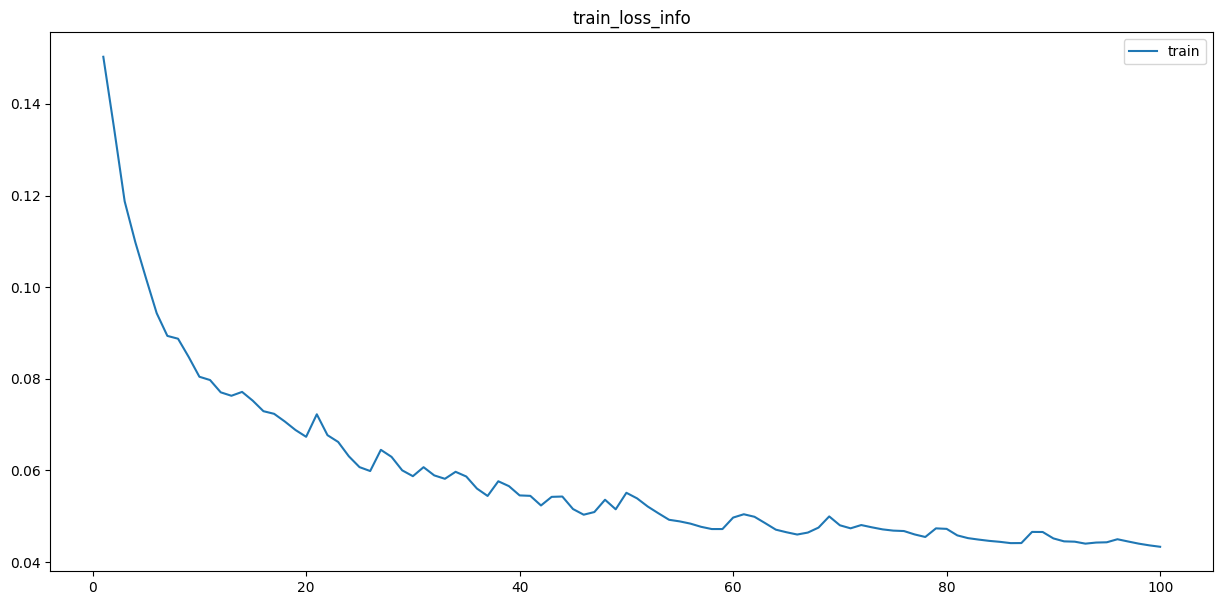

In [55]:
plt.figure(figsize=(15,7))
plt.title('train_loss_info')
plt.plot(ep, train_loss_info, label='train')
plt.legend()

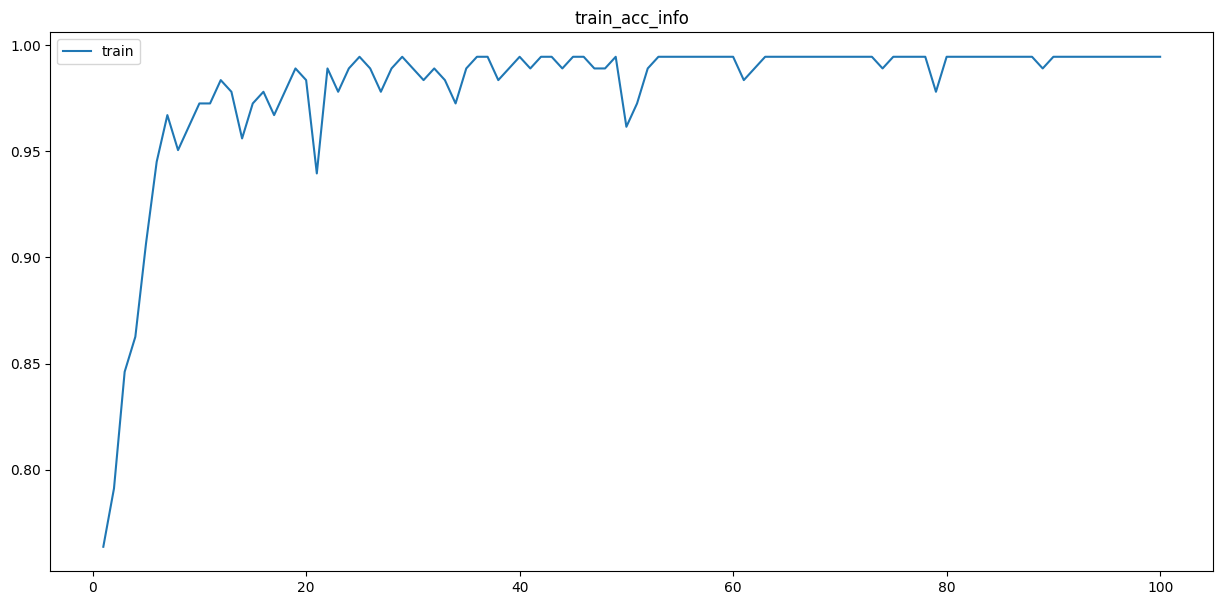

In [64]:
plt.figure(figsize=(15,7))
plt.title('train_acc_info')
plt.plot(ep, train_acc_info, label='train')
plt.legend()

Plot val Acc, loss

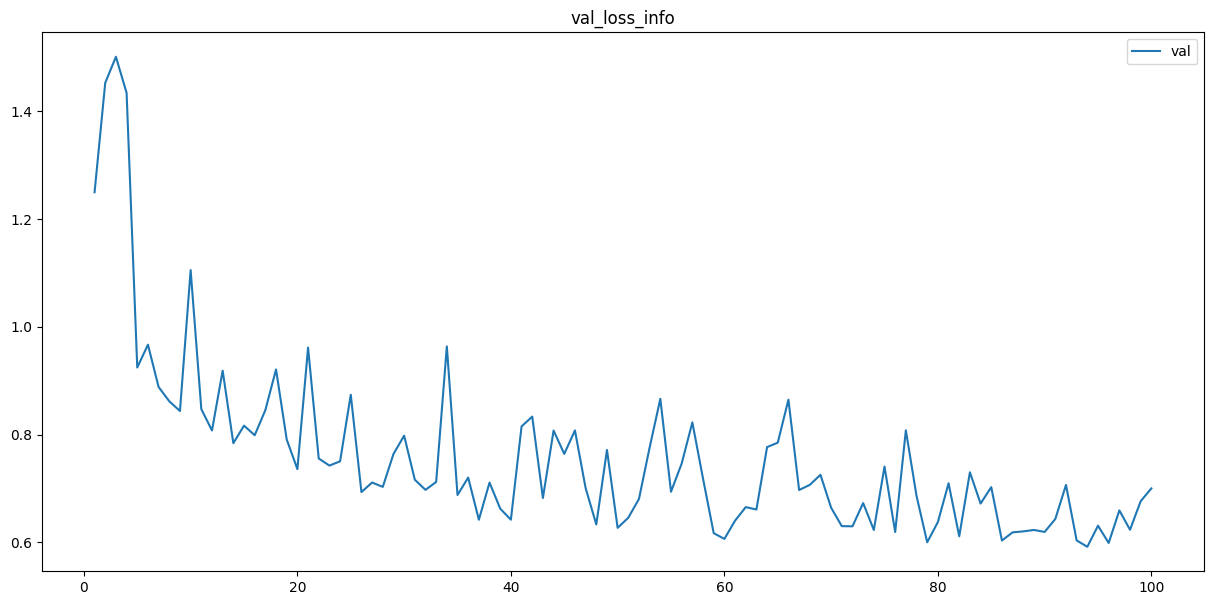

In [56]:
plt.figure(figsize=(15,7))
plt.title('val_loss_info')
plt.plot(ep,val_loss_info, label='val')
plt.legend()

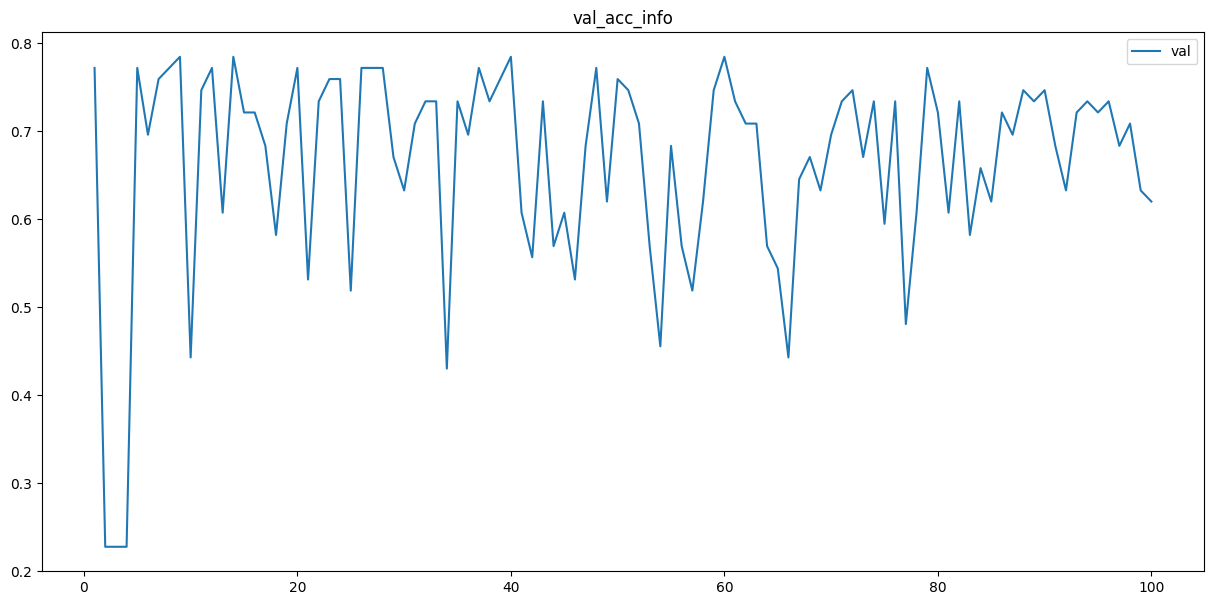

In [65]:
plt.figure(figsize=(15,7))
plt.title('val_acc_info')
plt.plot(ep, val_acc_info, label='val')
plt.legend()

# 13. Save Model

In [57]:
PATH='C:\\Users\\PC00\\Desktop\\ASD_data\\model\\T2\\'

In [58]:
torch.save(model, PATH+'model.pt') #전체 모델 저장
torch.save(model.state_dict(), PATH+'model_state_dict.pt') #모델 객체의 state_dict 저장
torch.save({
    'model':model.state_dict(),
    'optimizer':optimizer.state_dict()
}, PATH+'all.tar') #여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar 값 저장 가능

# 14. Test

In [59]:
model=torch.load(PATH+'model.pt') #전체 모델을 통째로 불러옴
model.load_state_dict(torch.load(PATH+'model_state_dict.pt')) #state_dict를 불러 온 후, 모델에 저장

checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

model.to(device)

ResNet18(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (cbam): CBAM(
        (ChannelGate): ChannelGate(
          (mlp): Sequential(
            (0): Flatten()
            (1): Linear(in_features=64, out_features=4, bias

In [60]:
#sensitivity
#양성인 것중에 양성으로 판별

#specificity
#음성인 것중에 음성으로 판별

def true_positive(p,t):
    l=len(p)
    cnt=0
    for i in range(l):
        if t[i]==1 and p[i]==1:
            cnt+=1
            
    return cnt


def true_negative(p,t):
    l=len(p)
    cnt=0
    for i in range(l):
        if t[i]==0 and p[i]==0:
            cnt+=1
    
    return cnt

In [61]:
def test_loop(dataloader,model, loss_fn, test_asd, test_tc):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    model.eval()
    
    test_loss, correct=0,0
    
    TP,TN=0,0
    
    with torch.no_grad():
        for X,y in dataloader:
            X=Variable(X.to(device).float())
            y=Variable(y.to(device).float())
            
            pred=model(X)
            
            #loss
            test_loss+=loss_fn(pred, y).item()
            #accuracy
            correct+=(pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
            print(pred.argmax(1))
            print(y.argmax(1))
            print()
            TP+=true_positive(pred.argmax(1), y.argmax(1))
            TN+=true_negative(pred.argmax(1), y.argmax(1))
    
    FN=test_asd-TP
    FP=test_tc-TN
    test_loss/=num_batches
    correct/=size
    
    print(f"Test Error\n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {test_loss:>8f}\n")
    print(f"True Positive : {TP}\nTrue Negative : {TN}\nFalse Positive : {FP}\nFalse Negative : {FN}\n")
    return (TP/(TP+FN))*100, (TN/(FP+TN))*100, (TP/(TP+FP))*100, (TN/(FN+TN))*100

In [62]:
test_asd=10
test_tc=10

start=time.time()

sensitivity, specificity, PPV, NPV=test_loop(test_dataloader ,model, loss_fn, test_asd, test_tc)

end=time.time()

print(f"Test 걸린 시간 : {(end-start)//60} 분 {(end-start)%60:.1f} 초")

tensor([0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
tensor([1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')

tensor([0, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
tensor([0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')

tensor([1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 1, 0], device='cuda:0')

Test Error
 Accuracy : 40.0%, Avg Loss : 0.871802

True Positive : 5
True Negative : 3
False Positive : 7
False Negative : 5

Test 걸린 시간 : 0.0 분 4.5 초


In [63]:
print(f"Sensitivity : {sensitivity:.3f}%")
print(f"Specificity : {specificity:.3f}%")
print(f"PPV : {PPV:.3f}%")
print(f"NPV : {NPV:.3f}%")

Sensitivity : 50.000%
Specificity : 30.000%
PPV : 41.667%
NPV : 37.500%
